In [1]:
import pkg_resources
pkg_resources.require("matplotlib==3.1.2")

import pandas as pd
import re
import base64
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import lzma
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer

In [2]:
df_train = pd.read_csv("/Users/michelle/data/kaggle_train_data_tab.csv", sep='\t')
# df_test = pd.read_csv("/Users/michelle/data/kaggle_test_data_tab.csv", sep='\t')

In [3]:
def get_content(page_base64):
    try:
        return BeautifulSoup(base64.b64decode(page_base64).decode("utf-8"), "html.parser")
    except UnicodeDecodeError:
        return

def get_text(content):
    if content:
        for s in content(["style", "script", "[document]", "head", "title"]):
            s.extract()
        text = content.get_text(separator=" ")
        text = re.sub("\s+", " ", text)
    else:
        text = ""
    return text

def get_words_count(text):
    return len(text.split(' '))

def get_mean_word_length(text):
    word_length_list = [len(word) for word in text.split(' ')]
    return sum(word_length_list) / len(word_length_list)

def get_title_words_count(content):
    title = content.find("title")
    if title:
        return len(title.get_text().split())
    else:
        return 0

def get_compression_value(html):
    return len(html) / len(lzma.compress(html))

def get_anchor_words_count(content):
    anchor_list = [anchor.get_text() for anchor in content.find_all("a")]
    counter = 0
    for anchor in anchor_list:
        counter += len(anchor.split(' '))
    return counter



def take_them_all(page_base64):
    try:
        content = get_content(page_base64)
        compression_value = get_compression_value(base64.b64decode(page_base64))
        if content:
            title_words_count = get_title_words_count(content)
            anchor_words_count = get_anchor_words_count(content)

            text = get_text(content)
            words_count = get_words_count(text)
            mean_word_length = get_mean_word_length(text)

            return (words_count, mean_word_length,
                    title_words_count, compression_value, anchor_words_count)
        
        else:
            return "Error"
    
    except Exception as e:
        print(page_base64)
        raise e


In [4]:
tqdm.pandas()
df_train["features"] = df_train["PageBase64"].progress_apply(take_them_all)

df_train = df_train.drop(df_train[df_train["features"] == "Error"].index, 0)

for feature in range(5):
    df_train[f"{feature}_feature"] = df_train["features"].apply(lambda x: float(x[feature]))

df_train = df_train.drop(["features"], 1)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
kfold = KFold(n_splits=5, shuffle=True)

In [9]:
def optimize_threshold_f1(pred, test):
    ths_array = np.sort(np.unique(pred))
    f1_weighted_auto = []

    for th in tqdm(ths_array, total=ths_array.shape[0]):
        f1_weighted_auto.append(f1_score(test, pred > th, average="weighted"))
        
    return ths_array[np.argmax(f1_weighted_auto)], np.max(f1_weighted_auto)

In [10]:
th = 0
f1_weighted_auto = 0
for train_indices, test_indices in kfold.split(df_train):
    model = LogisticRegression()
    
    X_train = df_train.iloc[train_indices, :].loc[:, [f"{feature}_feature" for feature in range(5)]]
    y_train = df_train.iloc[train_indices, :].loc[:, ["Prediction"]]
    model.fit(X_train, y_train)
    
    X_test = df_train.iloc[test_indices, :].loc[:, [f"{feature}_feature" for feature in range(5)]]
    y_test = df_train.iloc[test_indices, :].loc[:, ["Prediction"]]
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_test)[:, 1], y_test)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    

th /= kfold.get_n_splits()
f1_weighted_auto /= kfold.get_n_splits()
print(th, f1_weighted_auto)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



0.6132884816164466 0.7110340221306901


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Количество ссылок и их отношение к размеру страницы

In [45]:
def get_links_number(page_base64):
    content = get_content(page_base64)
    if content:
        return len(content.find_all("a"))

In [46]:
tqdm.pandas()
df_train["num_links"] = df_train["PageBase64"].progress_apply(get_links_number)

In [47]:
df_train["link_value"] = df_train["num_links"] / df_train["0_feature"]

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


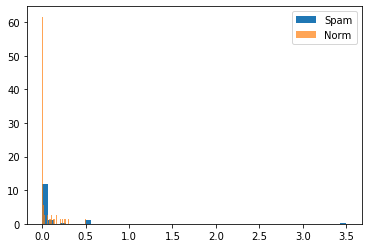

In [49]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["num_links"] < 10)]["link_value"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["num_links"] < 10)]["link_value"], bins=50, label="Norm", normed=True, alpha=0.7)
plt.legend()

In [53]:
th = 0
f1_weighted_auto = 0

train_subset = [f"{feature}_feature" for feature in range(5)] + ["link_value"]

for train_indices, test_indices in kfold.split(df_train):
    model = LogisticRegression()
    
    X_train = df_train.iloc[train_indices, :].loc[:, train_subset]
    y_train = df_train.iloc[train_indices, :].loc[:, ["Prediction"]]
    model.fit(X_train, y_train)
    
    X_test = df_train.iloc[test_indices, :].loc[:, train_subset]
    y_test = df_train.iloc[test_indices, :].loc[:, ["Prediction"]]
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_test)[:, 1], y_test)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    

th /= kfold.get_n_splits()
f1_weighted_auto /= kfold.get_n_splits()
print(th, f1_weighted_auto)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



0.6183874956267986 0.7122441206614556


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# RandomForest

In [65]:
th = 0
f1_weighted_auto = 0

train_subset = [f"{feature}_feature" for feature in range(5)] + ["link_value"]

for train_indices, test_indices in kfold.split(df_train):
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    
    X_train = df_train.iloc[train_indices, :].loc[:, train_subset]
    y_train = df_train.iloc[train_indices, :].loc[:, ["Prediction"]]
    model.fit(X_train, y_train)
    
    X_test = df_train.iloc[test_indices, :].loc[:, train_subset]
    y_test = df_train.iloc[test_indices, :].loc[:, ["Prediction"]]
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_test)[:, 1], y_test)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    

th /= kfold.get_n_splits()
f1_weighted_auto /= kfold.get_n_splits()
print(th, f1_weighted_auto)

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()



0.496 0.8879009522561091


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
def get_links_number(content):
#     content = get_content(page_base64)
    if content:
        return len(content.find_all("a"))

In [72]:
def take_them_all(page_base64):
    try:
        content = get_content(page_base64)
        compression_value = get_compression_value(base64.b64decode(page_base64))
        if content:
            title_words_count = get_title_words_count(content)
            anchor_words_count = get_anchor_words_count(content)
            num_links = get_links_number(content)

            text = get_text(content)
            words_count = get_words_count(text)
            mean_word_length = get_mean_word_length(text)

            return (words_count, mean_word_length,
                    title_words_count, compression_value, anchor_words_count, num_links / words_count)
        
        else:
            return "Error"
    
    except Exception as e:
        print(page_base64)
        raise e

In [73]:
tqdm.pandas()
df_test["features"] = df_test["PageBase64"].progress_apply(take_them_all)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [82]:
df_test = df_test.drop(df_test[df_test["features"] == "Error"].index, 0)

for feature in range(5):
    df_test[f"{feature}_feature"] = df_test["features"].apply(lambda x: float(x[feature]))
    
df_test["link_value"] = df_test["features"].apply(lambda x: float(x[5]))

In [85]:
train_subset = [f"{feature}_feature" for feature in range(5)] + ["link_value"]
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(df_train.loc[:, train_subset], df_train["Prediction"])
pred = model.predict_proba(df_train.loc[:, train_subset])[:, 1]
optimize_threshold_f1(pred, df_train["Prediction"])

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.45, 1.0)

In [86]:
pred = model.predict_proba(df_test.loc[:, train_subset])[:, 1]
df_test["Prediction"] = pred > th
df_test["Prediction"] = df_test["Prediction"].apply(lambda x: int(x))
df_test.head()

,Id,Prediction,Url,PageBase64,features,0_feature,1_feature,2_feature,3_feature,4_feature,links_value,link_value
0,-9219333997282093076,1,http://laventuhhl.ohugi.com/igor-znakomstva-ni...,PGh0bWw+DQoNCjxoZWFkPg0KPE1FVEEgY29udGVudD0idG...,"(771, 5.979247730220493, 9, 3.2471719457013575...",771.0,5.979248,9.0,3.247172,79.0,0.029831,0.029831
1,-9216796593526314243,1,http://myachina9abbee.front.ru/allinone.html,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,"(485, 5.536082474226804, 5, 2.8793840889649274...",485.0,5.536082,5.0,2.879384,72.0,0.074227,0.074227
2,-9216634615606576667,0,http://petropavl.kz/whouse/autor/autor4.shtml,PCEtLdCY0LTQtdGPINGB0L7Qt9C00LDQvdC40Y8g0Lgg0L...,"(220, 6.5590909090909095, 13, 3.34477002967359...",220.0,6.559091,13.0,3.344770,24.0,0.095455,0.095455
3,-9215626373068452590,0,http://astro-online.ru/synastry.html,CjwhRE9DVFlQRSBIVE1MIFBVQkxJQyAiLS8vVzNDLy9EVE...,"(3008, 6.550199468085107, 4, 11.13009381413075...",3008.0,6.550199,4.0,11.130094,48.0,0.010971,0.010971
4,-9215403080479774736,1,http://oxoyhetc.hopto.org/13/62.html,DQoNCg0KPEhUTUw+DQo8SEVBRD4NCjx0aXRsZT7QotC10L...,"(665, 6.225563909774436, 7, 3.6098242811501597...",665.0,6.225564,7.0,3.609824,95.0,0.034586,0.034586


In [87]:
df_test.loc[:, ["Id", "Prediction"]].to_csv("antispam_submission_07_01.csv", index=False)

# Текстовые фичи

In [9]:
stemmer = SnowballStemmer('russian')

In [7]:
# def get_keywords(page_base64):
#     content = get_content(page_base64)
#     keywords = []
#     if content:
#         for tag in content.find_all("meta"):
#             try:
#                 tag_text = tag["content"]
#                 if tag_text:
#                     keywords += [stemmer.stem(word).lower() for word in re.sub(r"[^\w\s]", ' ', tag_text).split(" ")]
#             except:
#                 pass
#     return re.sub("\d+", "", re.sub("\s+", " ", (" ".join(keywords))))

In [12]:
# tqdm.pandas()
# df_train["keywords"] = df_train["PageBase64"].progress_apply(get_keywords)

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
def standart_text(text):
    text = re.sub("\d+", "", re.sub("\s+", " ", re.sub(r"[^\w\s]", ' ', text)))
    text = " ".join([stemmer.stem(word).lower() for word in text.split(" ") if len(word) > 2])
    return text

In [6]:
tqdm.pandas()
df_train["text"] = df_train["PageBase64"].progress_apply(lambda x: standart_text(get_text(get_content(x))))

/usr/local/lib/python3.7/site-packages/tqdm/std.py:651: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
df_train.head()

,Id,Prediction,Url,PageBase64,text
0,-9222401963271173253,0,http://lawleader.ru/docs/32/,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,главн компан услуг бизнес договор новост юриди...
1,-9221399504663603656,0,http://alterhost.ruwww.alterhost.ruwww.user.kz...,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,главн форум обсужден блог творчеств открытк ре...
2,-9219733223042265364,0,http://www.ferio.ru/c_1-acura-legend.html,PCFET0NUWVBFIEhUTUwgUFVCTElDICItLy9XM0MvL0RURC...,ваш регион москв санкт петербург сибирск южн у...
3,-9218561774155397294,0,http://fshops.otzyv.ru/read.php?id=277,PCFET0NUWVBFIEhUTUwgUFVCTElDICItLy9XM0MvL0RURC...,как повес штор форум туризм кин авт магазин ко...
4,-9216163564171210203,1,http://penhea895.narod.ru/familiya-shushmarche...,PCFET0NUWVBFIGh0bWwgUFVCTElDICItLy9XM0MvL0RURC...,рамблер поиск ещ авторамблер ауд афиш блог гор...


In [7]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_train["text"].fillna(''))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
data_vect.shape

In [24]:
mean_tfidf = data_vect.mean(axis=1)

In [26]:
df_train["mean_tfidf"] = mean_tfidf

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


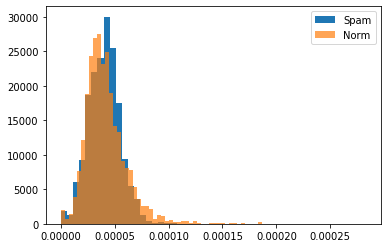

In [27]:
plt.hist(df_train[(df_train["Prediction"] == 1)]["mean_tfidf"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0)]["mean_tfidf"], bins=50, label="Norm", normed=True, alpha=0.7)
plt.legend()

In [14]:
doc_lengths = np.array(df_train["text"].apply(lambda x: len(x.split())))

In [32]:
mean_html_tfidf = data_vect.sum(axis=1) / doc_lengths

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [33]:
df_train["mean_html_tfidf"] = mean_tfidf

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


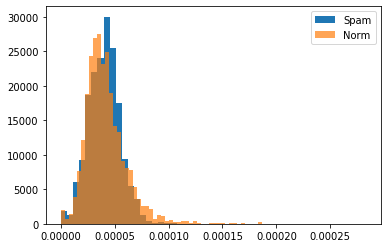

In [34]:
plt.hist(df_train[(df_train["Prediction"] == 1)]["mean_html_tfidf"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0)]["mean_html_tfidf"], bins=50, label="Norm", normed=True, alpha=0.7)
plt.legend()

In [8]:
count_vectorizer = CountVectorizer()
data_count = count_vectorizer.fit_transform(df_train["text"].fillna('')).todense()

In [10]:
data_count.shape

(7044, 271805)

In [11]:
vectorizer.idf_.shape

(271805,)

In [9]:
data_idf = np.multiply(data_count, vectorizer.idf_)

In [15]:
df_train["mean_idf"] = data_idf.mean(axis=1)

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


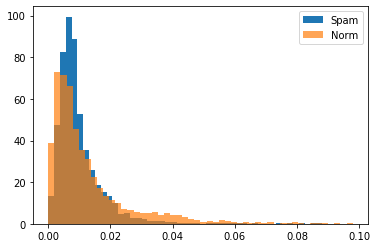

In [18]:
plt.hist(df_train[(df_train["Prediction"] == 1) & (df_train["mean_idf"] < 0.1)]["mean_idf"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0) & (df_train["mean_idf"] < 0.1)]["mean_idf"], bins=50, label="Norm", normed=True, alpha=0.7)
plt.legend()

In [19]:
df_train = df_train.drop(["mean_idf"], 1)

_____________________________

In [10]:
doc_lengths = np.array(df_train["text"].apply(lambda x: len(x.split())))

In [23]:
doc_lengths.shape

(7044,)

In [12]:
sample = data_idf[:10, :]

In [17]:
sample_length = doc_lengths[0:10]

In [30]:
sample.sum(1).reshape(-1)

matrix([[8763.89622277, 1432.6847721 , 3311.11686563, 1585.69182339,
         1652.84595515, 2654.14349544, 1528.89925025, 1030.37133702,
         3610.15971312,  681.63261432]])

In [37]:
np.array(sample.sum(1).reshape(sample.shape[0]) / sample_length)[0]

array([3.85056952, 4.87307746, 4.94196547, 3.97416497, 4.72241701,
       3.73823028, 4.77781016, 4.04067191, 4.29269883, 3.91742882])

In [38]:
df_train["mean_html_idf"] = np.array(data_idf.sum(axis=1).reshape(-1) / doc_lengths)[0]

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.
/Users/michelle/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


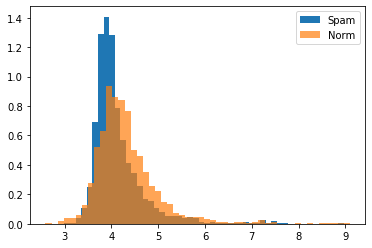

In [39]:
plt.hist(df_train[(df_train["Prediction"] == 1)]["mean_html_idf"], bins=50, label="Spam", normed=True)
plt.hist(df_train[(df_train["Prediction"] == 0)]["mean_html_idf"], bins=50, label="Norm", normed=True, alpha=0.7)
plt.legend()

In [42]:
df_train = df_train.drop(["text"], 1)

In [43]:
df_train.to_csv("df_train_idf.csv", index=False)

In [55]:
df_train[train_subset].isnull().sum()

0_feature         0
1_feature         0
2_feature         0
3_feature         0
4_feature         0
link_value        0
mean_html_idf    63
dtype: int64

In [56]:
th = 0
f1_weighted_auto = 0

train_subset = [f"{feature}_feature" for feature in range(5)] + ["link_value", "mean_html_idf"]

for train_indices, test_indices in kfold.split(df_train):
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    
    X_train = df_train.iloc[train_indices, :].loc[:, train_subset].fillna(0)
    y_train = df_train.iloc[train_indices, :].loc[:, ["Prediction"]].fillna(0)
    model.fit(X_train, y_train)
    
    X_test = df_train.iloc[test_indices, :].loc[:, train_subset].fillna(0)
    y_test = df_train.iloc[test_indices, :].loc[:, ["Prediction"]].fillna(0)
    tmp_th, tmp_f1_weighted_auto = optimize_threshold_f1(model.predict_proba(X_test)[:, 1], y_test)
    
    th += tmp_th
    f1_weighted_auto += tmp_f1_weighted_auto
    

th /= kfold.get_n_splits()
f1_weighted_auto /= kfold.get_n_splits()
print(th, f1_weighted_auto)

/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/michelle/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()



0.49000000000000005 0.8966500061630738


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
# train_subset = [f"{feature}_feature" for feature in range(5)] + ["link_value"]
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
model.fit(df_train.loc[:, train_subset].fillna(0), df_train["Prediction"].fillna(0))
pred = model.predict_proba(df_train.loc[:, train_subset].fillna(0))[:, 1]
optimize_threshold_f1(pred, df_train["Prediction"])

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.44, 1.0)

In [58]:
import pickle

In [59]:
pickle.dump(model, open("model_07_01.pkl", 'wb'))

In [60]:
del data_count
del data_idf
del df_train

# Prepare test

In [10]:
tqdm.pandas()
df_test["text"] = df_test["PageBase64"].progress_apply(lambda x: standart_text(get_text(get_content(x))))

In [11]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_test["text"].fillna(''))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [12]:
count_vectorizer = CountVectorizer()
data_count = count_vectorizer.fit_transform(df_test["text"].fillna('')).todense()

In [ ]:
data_idf = np.multiply(data_count, vectorizer.idf_)

In [ ]:
doc_lengths = np.array(df_test["text"].apply(lambda x: len(x.split())))

In [ ]:
df_test["mean_html_idf"] = np.array(data_idf.sum(axis=1).reshape(-1) / doc_lengths)[0]

In [ ]:
df_test = df_test.drop(["text"], 1)
df_test.to_csv("df_test_idf.csv", index=False)